https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [25]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Bidirectional, TimeDistributed, Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from keras import backend as K
from tensorflow.keras.utils import plot_model

ImportError: cannot import name 'scaler' from 'tensorflow.keras.layers' (c:\Users\chust\anaconda3\Lib\site-packages\keras\api\_v2\keras\layers\__init__.py)

In [2]:
# load final clean dataset
df = pd.read_csv('merged_clean_data.csv')

In [3]:
# columns to exclude
sectors_todrop = ['Utilities', 'Educational services', 'Accommodation and food services', 'Other services except public administration',
                  'Public administration', 'Finance and insurance, real estate and rental and leasing', 'Professional scientific and technical services',
                  'Information culture and recreation']
weather_data_todrop = ['Snow Grnd Last Day (cm)', 'Dir of Max Gust (10s deg)',
                       'Spd of Max Gust (km/h)']

df.drop(columns = sectors_todrop, inplace = True)
df.drop(columns = weather_data_todrop, inplace = True)


In [4]:
# convert 'Date/Time' to datetime format
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

# convert 'GeoUID' to string
df['GeoUID'] = df['GeoUID'].astype('str')

In [5]:
# set date time as index
# df.set_index('Date/Time', inplace = True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77938 entries, 0 to 77937
Data columns (total 23 columns):
 #   Column                                                                             Non-Null Count  Dtype         
---  ------                                                                             --------------  -----         
 0   provincename                                                                       77938 non-null  object        
 1   Longitude                                                                          77938 non-null  float64       
 2   Latitude                                                                           77938 non-null  float64       
 3   Region.Name                                                                        77938 non-null  object        
 4   Date/Time                                                                          77938 non-null  datetime64[ns]
 5   Construction                                         

Construction

In [7]:
construction = df['Construction']
construction = pd.DataFrame(construction)
construction = construction[construction['Construction'].notnull()]
construction

,Construction
0,0.484470
1,0.518876
2,0.535712
3,0.528170
4,0.578918
...,...
77908,0.909181
77909,0.861926
77910,0.890384
77911,0.886212


In [8]:
# define a function that will split the sequence into desired number of steps
def prepare_data(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]  # Assuming Construction is at column index 5
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [9]:
# number of time steps
n_steps = 12
# split into samples | will have features and target variables
X, y = prepare_data(construction, n_steps)

In [10]:
print(X.shape)
print(y.shape)

(70090, 12, 1)
(70090,)


In [11]:
# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(56072, 12, 1)
(56072,)
(14018, 12, 1)
(14018,)


In [13]:
# Define the initial LSTM model
model = Sequential()
model.add(LSTM(units=32,
               activation = 'relu',
               return_sequences = 'True', 
               input_shape=(n_steps, 1)))
model.add(Dense(units=1))

# to get the r_squared
def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[r_squared])

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, 
          epochs=10, 
          batch_size=264, 
          validation_split=0.2,
          verbose = 1,
          callbacks=[early_stopping])

# Evaluate the initial model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

Epoch 1/10
170/170 [==============================] - 9s 35ms/step - loss: 134989.0469 - r_squared: -3412.3635 - val_loss: 138881.1562 - val_r_squared: -3290.2485
Epoch 2/10
170/170 [==============================] - 5s 29ms/step - loss: 134083.1406 - r_squared: -3390.2930 - val_loss: 141126.2188 - val_r_squared: -3347.2859
Epoch 3/10
170/170 [==============================] - 4s 25ms/step - loss: 131415.1719 - r_squared: -3316.6997 - val_loss: 137245.5000 - val_r_squared: -3241.9658
Epoch 4/10
170/170 [==============================] - 3s 15ms/step - loss: 131746.2031 - r_squared: -3313.7063 - val_loss: 137637.6250 - val_r_squared: -3272.8289
Epoch 5/10
170/170 [==============================] - 3s 17ms/step - loss: 130234.6328 - r_squared: -3274.0676 - val_loss: 138673.2344 - val_r_squared: -3322.7021
Epoch 6/10
170/170 [==============================] - 3s 17ms/step - loss: 130851.7188 - r_squared: -3295.1418 - val_loss: 137471.2969 - val_r_squared: -3266.9324
Epoch 7/10
170/170 [==

In [14]:
# 2nd LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# to get the r_squared
def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[r_squared])

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, 
          epochs=10, 
          batch_size=264, 
          validation_split=0.2,
          verbose = 1,
          callbacks=[early_stopping])

# Evaluate the initial model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

Epoch 1/10
170/170 [==============================] - 9s 32ms/step - loss: 44002.4961 - r_squared: 0.5652 - val_loss: 16828.2285 - val_r_squared: 0.8468
Epoch 2/10
170/170 [==============================] - 5s 31ms/step - loss: 21154.4980 - r_squared: 0.8050 - val_loss: 23702.3848 - val_r_squared: 0.6711
Epoch 3/10
170/170 [==============================] - 5s 30ms/step - loss: 25137.7930 - r_squared: 0.7439 - val_loss: 16569.2637 - val_r_squared: 0.8453
Epoch 4/10
170/170 [==============================] - 5s 28ms/step - loss: 14005.7686 - r_squared: 0.8789 - val_loss: 10634.6768 - val_r_squared: 0.9111
Epoch 5/10
170/170 [==============================] - 5s 27ms/step - loss: 12473.6338 - r_squared: 0.8939 - val_loss: 13750.2041 - val_r_squared: 0.8866
Epoch 6/10
170/170 [==============================] - 6s 33ms/step - loss: 13189.1846 - r_squared: 0.8804 - val_loss: 10228.3740 - val_r_squared: 0.9250
Epoch 7/10
170/170 [==============================] - 5s 30ms/step - loss: 12085.6

In [27]:
# bidirectional LSTM (3rd)
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# to get the r_squared
def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[r_squared])

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, 
          epochs=50, 
          batch_size=264, 
          validation_split=0.2,
          verbose = 1,
          callbacks=[early_stopping])

model.summary()

# Evaluate the initial model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

Epoch 1/50
170/170 [==============================] - 9s 32ms/step - loss: 15011.4639 - r_squared: 0.8590 - val_loss: 4952.9863 - val_r_squared: 0.9530
Epoch 2/50
170/170 [==============================] - 5s 31ms/step - loss: 7514.0225 - r_squared: 0.9331 - val_loss: 2971.3547 - val_r_squared: 0.9703
Epoch 3/50
170/170 [==============================] - 4s 23ms/step - loss: 6395.4531 - r_squared: 0.9455 - val_loss: 2952.1174 - val_r_squared: 0.9714
Epoch 4/50
170/170 [==============================] - 5s 27ms/step - loss: 6739.8096 - r_squared: 0.9358 - val_loss: 3713.6443 - val_r_squared: 0.9685
Epoch 5/50
170/170 [==============================] - 4s 26ms/step - loss: 6262.0391 - r_squared: 0.9464 - val_loss: 3206.0220 - val_r_squared: 0.9701
Epoch 6/50
170/170 [==============================] - 4s 25ms/step - loss: 6108.9131 - r_squared: 0.9372 - val_loss: 2324.1125 - val_r_squared: 0.9755
Epoch 7/50
170/170 [==============================] - 4s 25ms/step - loss: 6008.5903 - r_squa

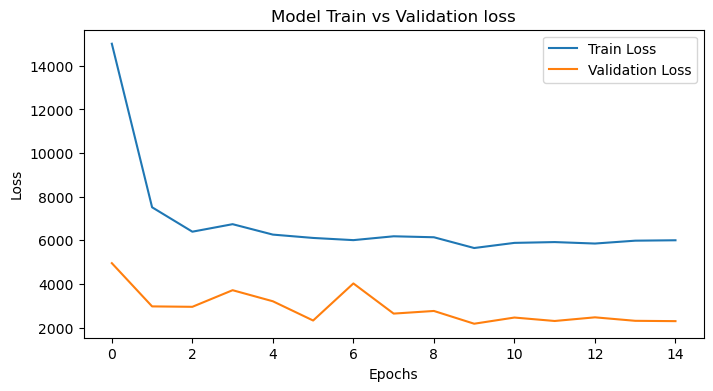

In [42]:
# plot the train and validation loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Train vs Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show();

In [34]:
y_test

array([  0.        ,  10.58213319,   4.45565041, ..., 146.7770938 ,
         8.75783764,  62.25440455])

In [40]:
y_pred = model.predict(X_test)
y_pred_flat = y_pred.flatten()


439/439 [==============================] - 2s 4ms/step


ValueError: x and y must have same first dimension, but have shapes (56072, 12, 1) and (14018,)

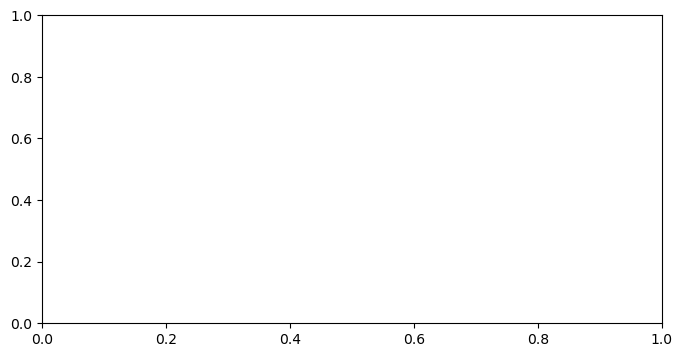

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the actual and predicted values
plt.figure(figsize=(8,4))
plt.plot(X_train, y_test, marker='.', label="actual")
plt.plot(X_train, y_pred_flat, 'r', label="prediction")

# Adjust layout and style
plt.tight_layout()
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()